**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 3: Neural Networks*

# Identification

Name: Yu-Chen Lee<br/>
Student Number: 300240688

Name: Matsuru Hoshi<br/>
Student Number: 300228879



## 1. Exploratory Analysis

### Loading the dataset

A custom dataset has been created for this assignment. It has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3)

Access and read the dataset directly from this GitHub repository in your Jupyter notebook.

You can use this code cell for you import statements and other initializations.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import tensorflow as tf
from keras import Sequential, layers, utils
import matplotlib.pyplot as plt


In [2]:
url1 = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_test.csv'
url2 = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_train.csv'
url3 = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_valid.csv'

test_df = pd.read_csv(url1)
train_df = pd.read_csv(url2)
valid_df = pd.read_csv(url3)

### Data Pre-Processing

2. **Shuffling the Rows**:

    - Since examples are generated by sliding a window across each protein sequence, most adjacent examples originate from the same protein and share 20 positions. To mitigate the potential negative impact on model training, the initial step involves shuffling the **rows** of the data matrix.

    In the code, **frac=1** keeps all rows while shuffling and **reset_index(drop=true)** resets the index after shuffling.

In [3]:
test_shuffled_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_shuffled_df

train_shuffled_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_shuffled_df

valid_shuffled_df = valid_df.sample(frac=1, random_state=42).reset_index(drop=True)
valid_shuffled_df

,2,0.05,0,0.4,0.6,0.10,0.1,0.11,0.35,0.12,0.1.1,0.13,0.14,0.16,0.17,0.18,0.19,0.20,0.3,0.21,0.1.2,0.22,0.23,0.1.3,0.24,0.26,0.27,0.28,0.75,0.29,0.30,0.31,0.32,0.33,0.34,0.36,0.37,0.38,0.15,0.39,...,0.322,0.323,0.324,0.325,0.326,0.327,0.328,0.329,0.330,0.05.46,0.331,0.332,0.333,0.05.47,0.334,0.335,0.75.1,0.336,0.05.48,0.337,0.338,0.9.1,0.339,0.340,0.341,0.342,0.343,0.344,0.345,0.05.49,0.346,0.347,0.348,0.349,0.350,0.351,0.352,0.353,0.354,0.355
0,2,0.0556,0.0000,0.0556,0.0000,0.0000,0.0000,0.0000,0.0000,0.0556,0.0556,0.0000,0.0556,0.0000,0.0556,0.0556,0.3333,0.1667,0.1111,0.0,0.0000,0.0000,0.0,0.0000,0.0556,0.0000,0.0556,0.0556,0.0556,0.0000,0.0000,0.0000,0.1667,0.0000,0.0556,0.0556,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0556,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0556,0.0000,0.7778,0.0556,0.0000,0.0,0.0556,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0556,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9444,0.0000,0.0
1,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0556,0.6667,...,0.0556,0.0556,0.0000,0.0000,0.1667,0.0000,0.0,0.1667,0.0000,0.0000,0.0000,0.0556,0.1667,0.0000,0.0,0.1111,0.1111,0.0,0.0000,0.0,0.0000,0.0000,0.1111,0.0556,0.0000,0.0556,0.0000,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0556,0.1111,0.0000,0.2778,0.0000,0.0
2,0,0.1373,0.0000,0.0196,0.0686,0.0000,0.0196,0.0294,0.0196,0.1176,0.1078,0.0196,0.0882,0.0196,0.0196,0.0294,0.1471,0.1176,0.0196,0.0,0.0098,0.0098,0.0,0.0196,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1373,0.0000,0.7059,0.0392,0.0294,0.0000,0.0000,0.0000,0.0098,0.0294,...,0.0098,0.0000,0.0588,0.0196,0.0882,0.0490,0.0,0.1078,0.0000,0.0882,0.0392,0.0784,0.0392,0.0294,0.0,0.0196,0.0098,0.0,0.0098,0.0,0.0000,0.0000,0.0490,0.0000,0.0000,0.0686,0.0000,0.5294,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.0000,0.0000,0.0098,0.0
3,0,0.0476,0.0000,0.0000,0.1429,0.0000,0.0000,0.0000,0.0000,0.0000,0.1905,0.0000,0.0000,0.0476,0.0000,0.0476,0.0476,0.0000,0.0952,0.0,0.0000,0.3810,0.0,0.0000,0.0000,0.0476,0.0476,0.0000,0.0000,0.0000,0.0476,0.0952,0.0000,0.0000,0.0000,0.0000,0.1905,0.0000,0.0000,0.1905,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.2381,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.0,0.0000,0.0000,0.0,0.0952,0.0,0.0000,0.0000,0.0476,0.0000,0.0000,0.0476,0.0952,0.1429,0.0476,0.0000,0.0000,0.0000,0.5238,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
4,1,0.0000,0.0098,0.0000,0.0000,0.7549,0.0000,0.0000,0.0000,0.0000,0.0392,0.0000,0.0000,0.0000,0.0000,0.0000,0.0098,0.0000,0.0098,0.0,0.1765,0.0000,0.0,0.0294,0.0000,0.0000,0.0196,0.0098,0.0000,0.0098,0.0294,0.1569,0.3529,0.0196,0.0294,0.0000,0.1078,0.0294,0.0490,0.0294,...,0.0000,0.0000,0.0000,0.0000,0.1765,0.0000,0.0,0.1765,0.0098,0.1176,0.0000,0.0098,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.1275,0.0,0.0196,0.0098,0.0000,0.0196,0.0000,0.0098,0.0588,0.0196,0.0098,0.0294,0.2353,0.0392,0.0294,0.1667,0.1471,0.0294,0.0392,0.0000,0.0098,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7403,0,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.0000,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.1667,0.1667,0.0000,0.0000,0.0000,0.0000,0.3333,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1667,0.0000,0.1667,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.3333,0.0000,0.0000,0.3333,0.0,0.0000,0.0000,0.0,0.3333,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.1667,0.0000,0.3333,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,

3. **Scaling of Numerical Features**:

    - Since all 462 features are proportions represented as values between 0 and 1, scaling may not be necessary. In our evaluations, using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) actually degraded model performance. Within your pipeline, compare the effects of not scaling the data versus applying [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In the interest of time, a single experiment will suffice. It is important to note that when scaling is applied, a uniform method should be used across all columns, given their homogeneous nature.

    To Separate the target column from the Dataframe, we use the **iloc** method. Features (X): extracts all the columns from the second onward. Target (y) extracts the first column whose index 0 as the target.

In [4]:
X = test_shuffled_df.iloc[:, 1:] # Features
y = test_shuffled_df.iloc[:, 0] # Target, first column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_with_scale = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

noscale_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_with_scale.fit(X_train,y_train)
noscale_pipeline.fit(X_train, y_train)

accuracy_no_scaling = accuracy_score(y_test, noscale_pipeline.predict(X_test))
accuracy_with_scaling = accuracy_score(y_test, pipeline_with_scale.predict(X_test))

print(f"Accuracy without scaling: {accuracy_no_scaling}")
print(f"Accuracy with MinMax scaling: {accuracy_with_scaling}")

Accuracy without scaling: 0.67182246133154
Accuracy with MinMax scaling: 0.67182246133154


4. **Isolating the Target and the Data**:

    - In the CSV files, the target and data are combined. To prepare for our machine learning experiments, separate the training data $X$ and the target vector $y$ for each of the three datasets.

In [5]:
X1 = test_shuffled_df.iloc[:, 1:] # Features
y1 = test_shuffled_df.iloc[:, 0] # Target, first column
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

X2 = train_shuffled_df.iloc[:, 1:] # Features
y2 = train_shuffled_df.iloc[:, 0] # Target, first column
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

X3 = valid_shuffled_df.iloc[:, 1:] # Features
y3 = valid_shuffled_df.iloc[:, 0] # Target, first column
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

### Model Development & Evaluation

5. **Model Development**:

    - **Dummy Model**: Implement a model utilizing the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). This model disregards the input data and predicts the majority class. Such model is sometimes called a straw man model.

    - **Baseline Model**: As a baseline model, select one of the previously studied machine learning algorithms: Decision Trees, K-Nearest Neighbors (KNN), or Logistic Regression. Use the default parameters provided by scikit-learn to train each model as a baseline. Why did you choose this particular classifier? Why do you think it should be appropriate for this specific task?

    - **Neural Network Model**: Utilizing [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org), construct a sequential model comprising an input layer, a hidden layer, and an output layer. The input layer should consist of 462 nodes, reflecting the 462 attributes of each example. The hidden layer should include 8 nodes and employ the default activation function. The output layer should contain three nodes, corresponding to the three classes: helix (0), sheet (1), and coil (2). Apply the softmax activation function to the output layer to ensure that the outputs are treated as probabilities, with their sum equaling 1 for each training example.

    We therefore have three models: dummy, baseline, and neural network.

In [6]:
dummy_model = DummyClassifier(strategy='most_frequent')

baseline_model = DecisionTreeClassifier(random_state=42)

nn_model = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])  
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6. **Model Evaluation**:

    - Employ cross-validation to assess the performance of the baseline model. Select a small number of folds to prevent excessive computational demands.

In [7]:
score = cross_val_score(baseline_model, X1_train, y1_train, cv= StratifiedKFold(n_splits=10))


**Training neural networks can be time-consuming.** Consequently, their performance is typically assessed once using a validation set. Make sure to not use the test set until the very end of the assignment.

In [9]:
y1_train_categorical = utils.to_categorical(y1_train)
y1_test_categorical = utils.to_categorical(y1_test)
nn_model.fit(X1_train, y1_train_categorical, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5736 - loss: 0.9133
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7241 - loss: 0.6809
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7279 - loss: 0.6639
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7356 - loss: 0.6262
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7443 - loss: 0.6068
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7664 - loss: 0.5666
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.5329
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.4935
Epoch 9/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8116 - loss: 0.4711
Epoch 10/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8239 - loss: 0.4441


Assess the models using metrics such as precision, recall, and F1-score.

In [12]:
dummy_model.fit(X1_train, y1_train)
y_pred_dummy = dummy_model.predict(X1_test)

baseline_model.fit(X1_train, y1_train)
y_pred_baseline = baseline_model.predict(X1_test)

y_pred_nn_prob = nn_model.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn_prob, axis = 1)

print("Dummy model Performance:")
print(classification_report(y1_test, y_pred_dummy))
print("Baseline model Performance:")
print(classification_report(y1_test, y_pred_baseline))
print("Neural Network model Performance:")
print(classification_report(y1_test, y_pred_nn))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Dummy model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       490
           1       0.00      0.00      0.00       376
           2       0.42      1.00      0.59       621

    accuracy                           0.42      1487
   macro avg       0.14      0.33      0.20      1487
weighted avg       0.17      0.42      0.25      1487

Baseline model Performance:
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       490
           1       0.37      0.40      0.39       376
           2       0.57      0.54      0.55       621

    accuracy                           0.50      1487
   macro avg       0.49      0.49      0.49      1487
weighted avg       0.50      0.50      0.50      1487

Neural Network model Performance:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       490
   

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

### Hyperparameter Optimization

7. **Baseline Model:**

    - To ensure a fair comparison for our baseline model, we will examine how varying hyperparameter values affect its performance. This prevents the erroneous conclusion that neural networks inherently perform better, when in fact, appropriate hyperparameter tuning could enhance the baseline model's performance.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

In [ ]:
# Code cell

8. **Neural Network:**

    In our exploration and tuning of neural networks, we focus on the following hyperparameters:

    - **Single hidden layer, varying the number of nodes**. 

        - Start with a single node in the hidden layer. Use a graph to depict the progression of loss and accuracy for both the training and validation sets, with the horizontal axis representing the number of training epochs and the vertical axis showing loss and accuracy. Training this network should be relatively fast, so let's conduct training for 50 epochs. Observing the graph, what do you conclude? Is the network underfitting or overfitting? Why?

        - Repeat the above process using 2 and 4 nodes in the hidden layer. Use the same type of graph to document your observations regarding loss and accuracy.

        - Start with 8 nodes in the hidden layer and progressively double the number of nodes until it surpasses the number of nodes in the input layer. This results in seven experiments and corresponding graphs for the following configurations: 8, 16, 32, 64, 128, 256, and 512 nodes. Document your observations throughout the process.
        
        - Ensure that the **number of training epochs** is adequate for **observing an increase in validation loss**. **Tip**: During model development, start with a small number of epochs, such as 5 or 10. Once the model appears to perform well, test with larger values, like 40 or 80 epochs, which proved reasonable in our tests. Based on your observations, consider conducting further experiments, if needed. How many epochs were ultimately necessary?

First of all, we define the model with a single node in the hidden layer. After training the model and validing metrics. We plotted the graph based on loss and accuracy with 50 epochs

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4679 - loss: 1.0536 - val_accuracy: 0.5857 - val_loss: 0.9616
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5872 - loss: 0.9616 - val_accuracy: 0.6032 - val_loss: 0.9326
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6019 - loss: 0.9135 - val_accuracy: 0.5931 - val_loss: 0.9238
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6108 - loss: 0.8898 - val_accuracy: 0.5985 - val_loss: 0.9058
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6234 - loss: 0.8738 - val_accuracy: 0.6120 - val_loss: 0.8849
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6200 - loss: 0.8642 - val_accuracy: 0.6066 - val_loss: 0.8814
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6176 - loss: 0.8589 - val_accuracy: 0.6140 - val_loss: 0.8695
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6240 - loss: 0.8468 - val_accuracy: 0.

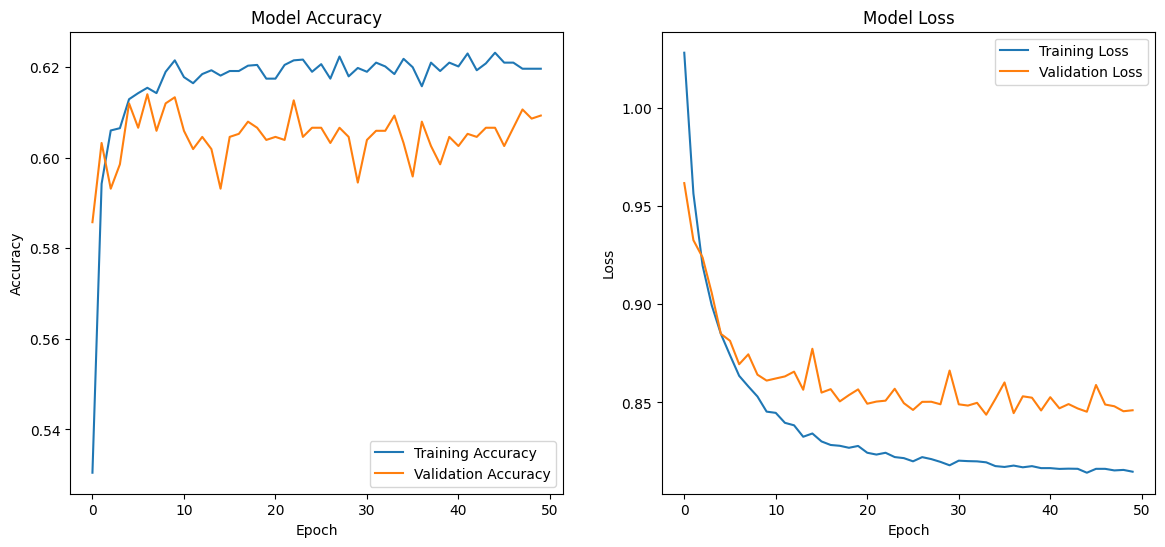

In [15]:
nn_model_single_node = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(1, activation= 'relu'),
    layers.Dense(3, activation='softmax')
])

nn_model_single_node.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model_single_node.fit(X1_train, y1_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X1_test, y1_test_categorical))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Both raining and validation accuracy appear to plateau around these levels, indicating that the model has likely learned as much as it can given its simple architecture. The training loss consistently decreases across epochs, which is a sign that the model is minimizing error on the training set. The low accuracy is around 0.6 for both training and validation. The model with one single node in the hidden layer is underfitting the data. It may not be sufficient to capture the complexities of the dataset with 462 features.

2 nodes

Epoch 1/50


C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4403 - loss: 1.0432 - val_accuracy: 0.5259 - val_loss: 0.9776
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5265 - loss: 0.9646 - val_accuracy: 0.5346 - val_loss: 0.9447
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5595 - loss: 0.9189 - val_accuracy: 0.6651 - val_loss: 0.9022
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6586 - loss: 0.8375 - val_accuracy: 0.6853 - val_loss: 0.8335
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7135 - loss: 0.7593 - val_accuracy: 0.6759 - val_loss: 0.8194
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7133 - loss: 0.7368 - val_accuracy: 0.6900 - val_loss: 0.7894
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7319 - loss: 0.7096 - val_accuracy: 0.6927 - val_loss: 0.7806
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7434 - loss: 0.6767 - val_accuracy: 0.6907 - val_

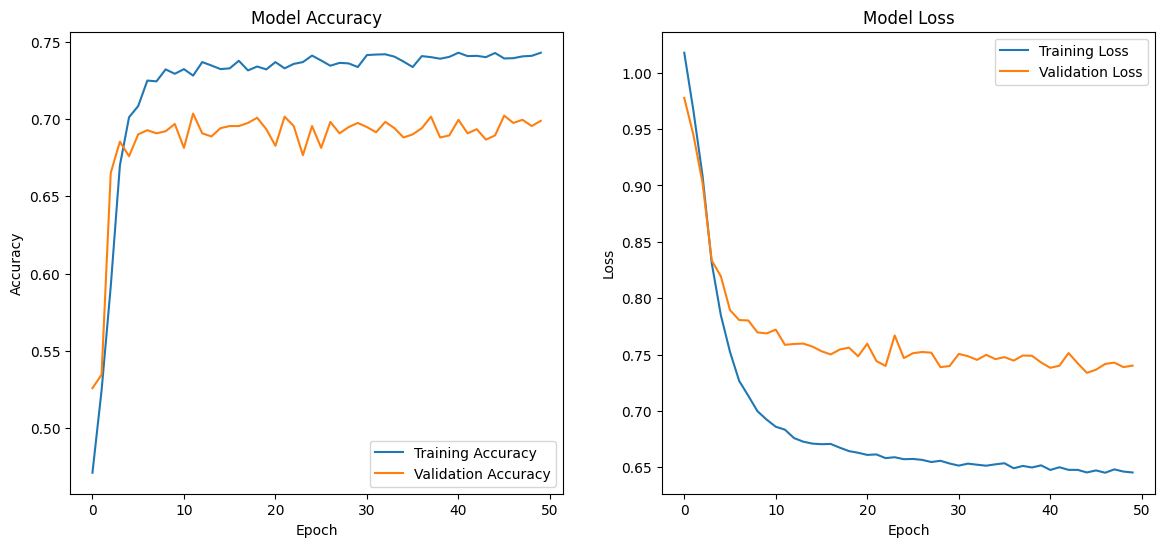

In [ ]:
nn_model_two_node = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(2, activation= 'relu'),
    layers.Dense(3, activation='softmax')
])

nn_model_two_node.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model_two_node.fit(X1_train, y1_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X1_test, y1_test_categorical))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


4 nodes

Epoch 1/50


C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5667 - loss: 0.9310 - val_accuracy: 0.7162 - val_loss: 0.7272
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7141 - loss: 0.6989 - val_accuracy: 0.7075 - val_loss: 0.7214
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7241 - loss: 0.6818 - val_accuracy: 0.7014 - val_loss: 0.7353
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7448 - loss: 0.6296 - val_accuracy: 0.7128 - val_loss: 0.7214
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7409 - loss: 0.6302 - val_accuracy: 0.7142 - val_loss: 0.7136
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7436 - loss: 0.6210 - val_accuracy: 0.7169 - val_loss: 0.7239
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7495 - loss: 0.6012 - val_accuracy: 0.7068 - val_loss: 0.7295
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7503 - loss: 0.6027 - val_accuracy: 0.7196 - val_

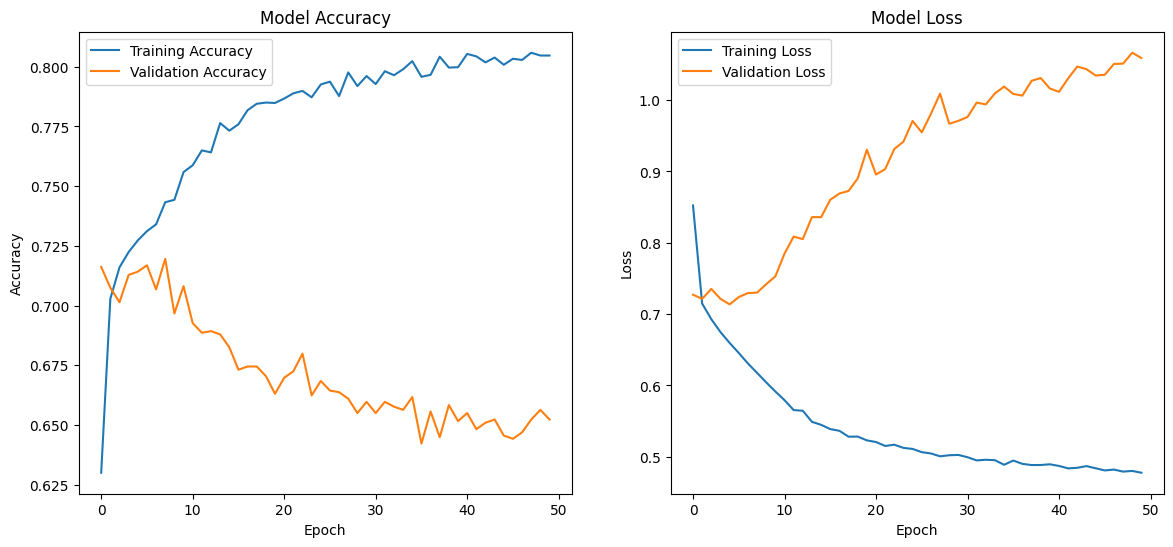

In [ ]:
nn_model_4_node = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(4, activation= 'relu'),
    layers.Dense(3, activation='softmax')
])

nn_model_4_node.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model_4_node.fit(X1_train, y1_train_categorical, epochs=50, batch_size=32, verbose=1, validation_data=(X1_test, y1_test_categorical))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


The rest of 7 experiments



Training model with 8 nodes in the hidden layer...
Epoch 1/10


C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5295 - loss: 0.9378 - val_accuracy: 0.7102 - val_loss: 0.7184
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7137 - loss: 0.6950 - val_accuracy: 0.7075 - val_loss: 0.7096
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7373 - loss: 0.6512 - val_accuracy: 0.6812 - val_loss: 0.7387
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7457 - loss: 0.6299 - val_accuracy: 0.7095 - val_loss: 0.7062
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7644 - loss: 0.5880 - val_accuracy: 0.7088 - val_loss: 0.7157
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7794 - loss: 0.5608 - val_accuracy: 0.7021 - val_loss: 0.7340
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8010 - loss: 0.5173 - val_accuracy: 0.6967 - val_loss: 0.7619
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8056 - loss: 0.4974 - val_accuracy: 0.6846 - val_

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5603 - loss: 0.9158 - val_accuracy: 0.7048 - val_loss: 0.7192
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7289 - loss: 0.6707 - val_accuracy: 0.7007 - val_loss: 0.7191
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7435 - loss: 0.6174 - val_accuracy: 0.7068 - val_loss: 0.7269
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7659 - loss: 0.5801 - val_accuracy: 0.7196 - val_loss: 0.7167
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8120 - loss: 0.4919 - val_accuracy: 0.7102 - val_loss: 0.7502
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8224 - loss: 0.4493 - val_accuracy: 0.7007 - val_loss: 0.7805
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8566 - loss: 0.3940 - val_accuracy: 0.6833 - val_loss: 0.8217
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8796 - loss: 0.3552 - val_accuracy: 0.6853 - val_

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5590 - loss: 0.9197 - val_accuracy: 0.7095 - val_loss: 0.7140
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7147 - loss: 0.6850 - val_accuracy: 0.7209 - val_loss: 0.7047
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7438 - loss: 0.6129 - val_accuracy: 0.7142 - val_loss: 0.7034
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7782 - loss: 0.5453 - val_accuracy: 0.7028 - val_loss: 0.7203
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8161 - loss: 0.4784 - val_accuracy: 0.7088 - val_loss: 0.7409
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8602 - loss: 0.3963 - val_accuracy: 0.6994 - val_loss: 0.7667
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8896 - loss: 0.3208 - val_accuracy: 0.6920 - val_loss: 0.8123
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9276 - loss: 0.2526 - val_accuracy: 0.6940 - val_

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5641 - loss: 0.9168 - val_accuracy: 0.7054 - val_loss: 0.7189
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7225 - loss: 0.6664 - val_accuracy: 0.7223 - val_loss: 0.7038
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7666 - loss: 0.5828 - val_accuracy: 0.7095 - val_loss: 0.7115
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7969 - loss: 0.5221 - val_accuracy: 0.7054 - val_loss: 0.7417
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8361 - loss: 0.4377 - val_accuracy: 0.6846 - val_loss: 0.7883
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8904 - loss: 0.3269 - val_accuracy: 0.6913 - val_loss: 0.8361
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9308 - loss: 0.2376 - val_accuracy: 0.6658 - val_loss: 0.8973
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9592 - loss: 0.1664 - val_accuracy: 0.6732 - val_

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5716 - loss: 0.9104 - val_accuracy: 0.7054 - val_loss: 0.7209
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7348 - loss: 0.6602 - val_accuracy: 0.7135 - val_loss: 0.7100
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7608 - loss: 0.5977 - val_accuracy: 0.7216 - val_loss: 0.7041
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8078 - loss: 0.5027 - val_accuracy: 0.7095 - val_loss: 0.7213
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8692 - loss: 0.3810 - val_accuracy: 0.7028 - val_loss: 0.7653
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9199 - loss: 0.2650 - val_accuracy: 0.6920 - val_loss: 0.8507
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9589 - loss: 0.1679 - val_accuracy: 0.6920 - val_loss: 0.9567
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9790 - loss: 0.1017 - val_accuracy: 0.6900 - val_

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6000 - loss: 0.8883 - val_accuracy: 0.7236 - val_loss: 0.7069
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7374 - loss: 0.6555 - val_accuracy: 0.7169 - val_loss: 0.7081
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7740 - loss: 0.5603 - val_accuracy: 0.7068 - val_loss: 0.7087
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8308 - loss: 0.4571 - val_accuracy: 0.7182 - val_loss: 0.7322
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8884 - loss: 0.3244 - val_accuracy: 0.7021 - val_loss: 0.8074
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - loss: 0.1931 - val_accuracy: 0.6994 - val_loss: 0.8726
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9808 - loss: 0.1100 - val_accuracy: 0.6980 - val_loss: 0.9761
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9905 - loss: 0.0629 - val_accuracy: 0.7014 - val_

C:\Users\leeyu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5521 - loss: 0.9099 - val_accuracy: 0.7162 - val_loss: 0.7070
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7264 - loss: 0.6577 - val_accuracy: 0.7115 - val_loss: 0.7202
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7843 - loss: 0.5548 - val_accuracy: 0.7149 - val_loss: 0.7193
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8459 - loss: 0.4262 - val_accuracy: 0.7142 - val_loss: 0.7797
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9041 - loss: 0.2838 - val_accuracy: 0.7108 - val_loss: 0.8029
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9538 - loss: 0.1740 - val_accuracy: 0.6974 - val_loss: 0.9750
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9798 - loss: 0.0983 - val_accuracy: 0.6980 - val_loss: 1.0631
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9941 - loss: 0.0457 - val_accuracy: 0.7014 - val_

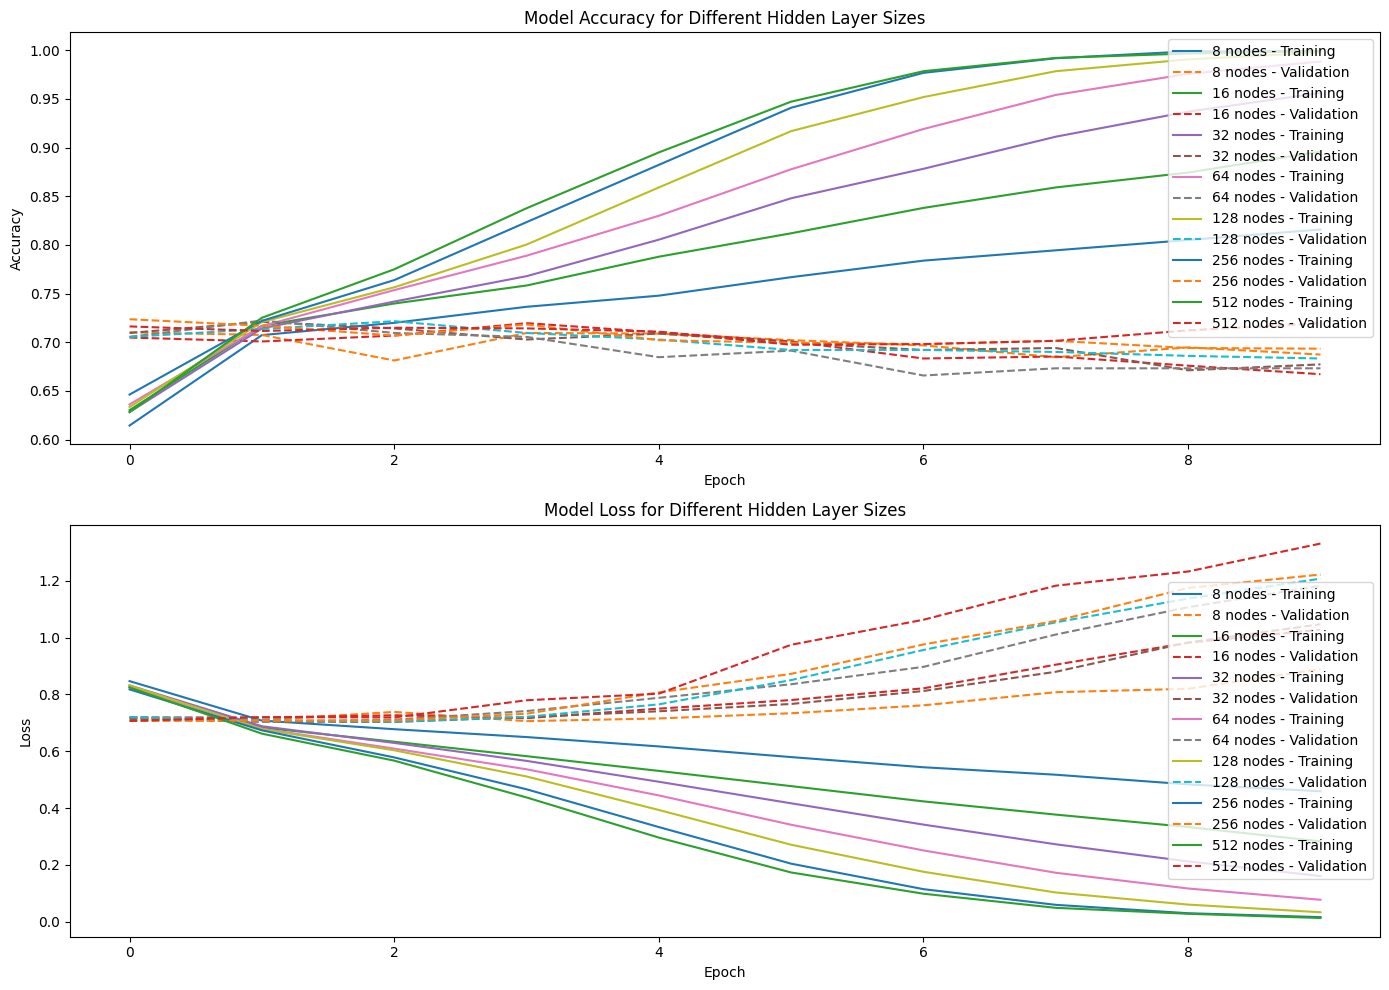

In [19]:
node_counts = [8, 16, 32, 64, 128, 256, 512]
history_dict = {}
for nodes in node_counts:
    print(f"\nTraining model with {nodes} nodes in the hidden layer...")
    nn_model_single_node = Sequential([
    layers.Dense(462, input_dim = 462),
    layers.Dense(nodes, activation= 'relu'),
    layers.Dense(3, activation='softmax')
    ])

    nn_model_single_node.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    history = nn_model_single_node.fit(X1_train, y1_train_categorical, epochs=10, batch_size=32, verbose=1, validation_data=(X1_test, y1_test_categorical))

    history_dict[nodes] = history.history

plt.figure(figsize=(14,10))
plt.subplot(2, 1, 1)
for nodes in node_counts:
    plt.plot(history_dict[nodes]['accuracy'], label=f'{nodes} nodes - Training')
    plt.plot(history_dict[nodes]['val_accuracy'], linestyle='--', label=f'{nodes} nodes - Validation')
plt.title('Model Accuracy for Different Hidden Layer Sizes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(2, 1, 2)
for nodes in node_counts:
    plt.plot(history_dict[nodes]['loss'], label=f'{nodes} nodes - Training')
    plt.plot(history_dict[nodes]['val_loss'], linestyle='--', label=f'{nodes} nodes - Validation')
plt.title('Model Loss for Different Hidden Layer Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Varying the number of layers**
Conduct similar experiments as described above, but this time vary the number of layers from 1 to 4. Document your findings.

How many nodes should each layer contain? Test at least two scenarios. Traditionally, a common strategy involved decreasing the number of nodes from the input layer to the output layer, often by halving, to create a pyramid-like structure. However, recent experience suggests that maintaining a constant number of nodes across all layers can perform equally well. Describe your observations. It is acceptable if both strategies yield similar performance results.

Select one your models that exemplifies overfitting. In our experiments, we easily constructed a model achieving nearly 100% accuracy on the training data, yet showing no similar improvement on the validation set. Present this neural network along with its accuracy and loss graphs. Explain the reasoning for concluding that the model is overfitting.

In [ ]:
# Code cell

**Activation function**.

Present results for one of the configurations mentioned above by varying the activation function. Test at least `relu` (the default) and `sigmoid`. The choice of the specific model, including the number of layers and nodes, is at your discretion. Document your observations accordingly.

In [ ]:
# Code cell

**Regularization** in neural networks is a technique used to prevent overfitting.

One technique involves adding a penalty to the loss function to discourage excessively complex models. Apply an `l2` penalty to some or all layers. Exercise caution, as overly aggressive penalties have been problematic in our experiments. Begin with the default `l2` value of 0.01, then reduce it to 0.001 and 1e-4. Select a specific model from the above experiments and present a case where you successfully reduced overfitting. Include a pair of graphs comparing results with and without regularization. Explain your rationale to conclude that overfitting has been reduced. Do not expect to completely eliminate overfitting. Again, this is a challenging dataset to work with.

In [ ]:
# Code cell

Dropout layers are a regularization technique in neural networks where a random subset of neurons is temporarily removed during training. This helps prevent overfitting by promoting redundancy and improving the network's ability to generalize to new data. Select a specific model from the above experiments where you have muliple layers and experiment adding one or of few dropout layers into your network. Experiment with two different rates, say 0.25 and 0.5. Document your observations.

In [ ]:
# Code cell

Summarize your experiments with using a graphical representation such as Figure 6.15 [on this page](https://egallic.fr/Enseignement/ML/ECB/book/deep-learning.html).

In [ ]:
# Code cell

Early stopping is a regularization technique in neural network training wherein the process is halted when validation set performance starts to decline, thus preventing overfitting by avoiding the learning of noise in the training data. From all the experiments conducted thus far, choose **one** configuration (the number of layers, number of nodes, activation function, L2 penalty, and dropout layers) that yielded the best performance. Use a graph of loss and accuracy to determine the optimal number of training iterations for this network. What is the optimal number of epochs for this network configuration and why?

In [ ]:
# Code cell

### Test

9. **Model Comparison**:

    - Evaluate the baseline model on the test set, using the optimal parameter set identified through grid search. Additionally, apply your best-performing neural network configuration to the test set.

    - Quantify the performance of the baseline model (best hyperparameter configuration) and your neural network (best configuration) using precision, recall, and F1-score as metrics. How do these two models compare to the dummy model?

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

In [ ]:
# Code cell

# Resources